In [1]:
%load_ext autoreload
%autoreload 2
%aimport -jax
%aimport -jaxlib

In [4]:
import jax
import jax.numpy as jnp
from jax.random import PRNGKey

from stanza.train import Trainer
from stanza.data import PyTreeData, Data

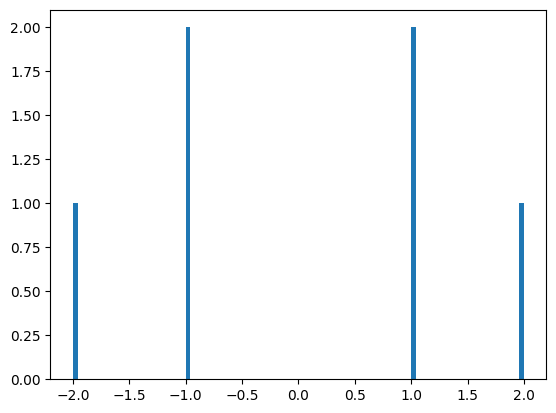

In [6]:
# create a dataset consisting of 4 deltas
data = Data.from_pytree(
    jnp.array([-2, -1, -1, 1, 1, 2])
)

def plot(samples):
    import matplotlib.pyplot as plt
    plt.hist(samples, bins=100)
    plt.show()
plot(data.data)

In [8]:
from typing import Sequence
from stanza.nets.util import SinusoidalPosEmbed
import flax.linen as nn

class MLP(nn.Module):
  features: Sequence[int]
  @nn.compact
  def __call__(self, x):
    for feat in self.features[:-1]:
      x = nn.relu(nn.Dense(feat)(x))
    x = nn.Dense(self.features[-1])(x)
    return x

class DiffuseMLP(nn.Module):
    features: Sequence[int]
    @nn.compact
    def __call__(self, noised_sample, timestep):
        sample_flat, sample_uf = jax.flatten_util.ravel_pytree(noised_sample)
        time_embed = SinusoidalPosEmbed(128)(timestep)
        x = jnp.concatenate((sample_flat, time_embed), axis=-1)
        x = MLP(self.features + [sample_flat.shape[-1]])(x)
        x = sample_uf(x)
        return x

model = DiffuseMLP([128, 256, 128])

In [9]:
from stanza.diffusion.ddpm import DDPMSchedule
from stanza.util import l2_norm_squared
from stanza.train import batch_loss as to_batch_loss

schedule = DDPMSchedule.make_squaredcos_cap_v2(100)

def loss(_, params, rng, sample):
    # generate noise
    t_rng, n_rng = jax.random.split(rng)
    timestep = jax.random.randint(t_rng, (), 0, schedule.num_steps)
    noised_sample, noise = schedule.add_noise(n_rng, sample, timestep)
    noise_pred = model.apply(params, noised_sample, timestep)
    return l2_norm_squared(noise, noise_pred)

batch_loss = to_batch_loss(loss)

In [13]:
from stanza.reporting.wandb import WandbDatabase
db = WandbDatabase("dpfrommer-projects/ddpm_example").create()

In [15]:
from stanza.reporting.jax import JaxDBScope
from stanza.util.rich import ConsoleDisplay, StatisticsTable, LoopProgress
import optax

db = JaxDBScope(db)
display = ConsoleDisplay()
display.add("train", StatisticsTable(), interval=100)
display.add("train", LoopProgress(), interval=100)

opt = optax.adam(1e-3)
init_params = model.init(PRNGKey(42), data[0], 0)

with display as w, db as db:
    trainer = Trainer(epochs=100, batch_size=32, optimizer=opt)
    logger_hook = db.statistic_logging_hook()
    res = trainer.train(
        batch_loss, data,
        PRNGKey(42), init_params,
        hooks=[w.train, logger_hook], jit=True
    )

TypeError: 'int' object is not subscriptable